# **Definición del problema:** 
<h2>Información</h2>
El conjunto de datos contiene 1000 entradas con 20 atributos entre Dimensiones y Medidas. En este conjunto de datos, cada entrada representa a una persona que toma un crédito de un banco. Cada persona se clasifica como riesgo de crédito bueno o malo según el conjunto de atributos.

<h2>Atributos</h2>
A continuación describimos algunos de los atributos codificados en el dataset:<br>
(DM) traduce Marcos Alemanes <i>'Moneda antes de 2002'</i>, el factor de conversión a euros es: 1 EUR ~ 1,9558 DM

<b> numéricos </b><br>
Atributo 2: Duración en meses <br>
Atributo 5: Monto de crédito en DM <br>
Atributo 8: Tasa de pago (en porcentaje del ingreso disponible) <br>
Atributo 11: Residencia actual desde<br>
Atributo 13: Edad en años<br>
Atributo 16: Número de créditos existentes con el banco<br>
Atributo 18: Número de personas que es responsable<br>

<b>Target value </b><br>
<b> status </b> ( Good or Bad - Riesgo )<br>

# **Librerias:** 
- Importando Librarias necesarias


In [101]:
import pandas as pd
import numpy as np
#---------------------------------------------------------------------------------------------------------------
from sklearn.preprocessing import LabelEncoder,MinMaxScaler
from sklearn.model_selection import GridSearchCV, train_test_split, KFold, cross_val_score ,ShuffleSplit,learning_curve
from sklearn.dummy import DummyClassifier
from collections import defaultdict
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix,accuracy_score , classification_report
#-Models--------------------------------------------------------------------------------------------------------
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
#---------------------------------------------------------------------------------------------------------------
from IPython.core.display import HTML # Tabla completa
#---------------------------------------------------------------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sn
%matplotlib inline

In [2]:
from ipywidgets import interact
from bokeh.models import ColumnDataSource
from bokeh.io import push_notebook, show, output_notebook
from bokeh.plotting import figure
from bokeh.palettes import viridis
from bokeh.models.widgets import Select ,Paragraph
from bokeh.layouts import widgetbox ,row
output_notebook()

Loading BokehJS ...

# **Datos:** 
- Importando Datos y renombrando atributos

In [32]:
dataset = pd.read_csv('data/GermanCreditData.csv', encoding='latin-1')
columns = ['checkin_account', 'duration', 'credit_history', 'purpose', 'credit_amount','saving_account', 'present_empl_since',
           'interest_rate', 'personal_status','other_debtors', 'residing_since', 'property', 'age','other_install_plans',
           'housing', 'num_credits','job', 'dependents', 'telephone', 'foreign_worker', 'status']
dataset.columns = columns
dataset['sex'] = dataset['personal_status'].map({'A91': 'M','A92': 'F','A93': 'M','A94': 'M','A95': 'F',})
varNumeric = list(dataset.select_dtypes(exclude=['object']).columns)
varDisc = list(dataset.select_dtypes(include=['object']).columns)
dataset['status'] = dataset['status'].map({1: 'Good', 2: 'Bad'})
HTML(dataset.head(7).to_html())

,checkin_account,duration,credit_history,purpose,credit_amount,saving_account,present_empl_since,interest_rate,personal_status,other_debtors,residing_since,property,age,other_install_plans,housing,num_credits,job,dependents,telephone,foreign_worker,status,sex
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,4,A121,67,A143,A152,2,A173,1,A192,A201,Good,M
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,2,A121,22,A143,A152,1,A173,1,A191,A201,Bad,F
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,3,A121,49,A143,A152,1,A172,2,A191,A201,Good,M
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,4,A122,45,A143,A153,1,A173,2,A191,A201,Good,M
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,4,A124,53,A143,A153,2,A173,2,A191,A201,Bad,M
5,A14,36,A32,A46,9055,A65,A73,2,A93,A101,4,A124,35,A143,A153,1,A172,2,A192,A201,Good,M
6,A14,24,A32,A42,2835,A63,A75,3,A93,A101,4,A122,53,A143,A152,1,A173,1,A191,A201,Good,M


In [4]:
#Informacion General de los atributos (cantidad, tipos y valores unicos)
print(dataset.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1001 entries, 0 to 1000
Data columns (total 22 columns):
checkin_account        1001 non-null object
duration               1001 non-null int64
credit_history         1001 non-null object
purpose                1001 non-null object
credit_amount          1001 non-null int64
saving_account         1001 non-null object
present_empl_since     1001 non-null object
interest_rate          1001 non-null int64
personal_status        1001 non-null object
other_debtors          1001 non-null object
residing_since         1001 non-null int64
property               1001 non-null object
age                    1001 non-null int64
other_install_plans    1001 non-null object
housing                1001 non-null object
num_credits            1001 non-null int64
job                    1001 non-null object
dependents             1001 non-null int64
telephone              1001 non-null object
foreign_worker         1001 non-null object
status              

In [5]:
print(dataset.nunique())

checkin_account          4
duration                33
credit_history           5
purpose                 10
credit_amount          921
saving_account           5
present_empl_since       5
interest_rate            4
personal_status          4
other_debtors            3
residing_since           4
property                 4
age                     53
other_install_plans      3
housing                  3
num_credits              4
job                      4
dependents               2
telephone                2
foreign_worker           2
status                   2
sex                      2
dtype: int64


# **Exploración de los datos:** 

- Starting by distribuition of column Age

In [33]:
dataset['records'] = 1
dataset.reset_index()
def update(atributo):
    pt = dataset.pivot_table(index='status',columns = atributo ,values='records',aggfunc='sum')
    colors = viridis(len(list(pt.columns)))
    source = ColumnDataSource(data=pt)
    p = figure(x_range=list(pt.index), plot_height=400,plot_width=800, title="Distribución "+atributo,toolbar_location=None, tools="")
    r = p.vbar_stack(list(pt.columns), x='status', width=0.5,
                             color=colors, source=source,legend=['| '+ str(x) for x in list(pt.columns)])
    show(p,notebook_handle=True)
    push_notebook()
    print(pt)

In [34]:
interact(update, atributo=varDisc)

interactive(children=(Dropdown(description='atributo', options=('checkin_account', 'credit_history', 'purpose'…

<function __main__.update(atributo)>

Parece conservarse una proporción en varios de los grupos al interior de los atributos cuando son comparardos entre "Buenos" y "Malos".<br>

Este dataset es un caso de un conjunto de datos desequilibrado, con el 70% de los individuos clasificados como "buen crédito".<br> Por lo tanto, la precisión de un modelo de clasificación debería ser superior al <b>70%</b>, que sería la precisión del modelo ingenuo que clasifica a cada individuo como un buen crédito.<br>

In [35]:
pd.DataFrame(dataset.status.value_counts( normalize=True ) )

,status
Good,0.7003
Bad,0.2997


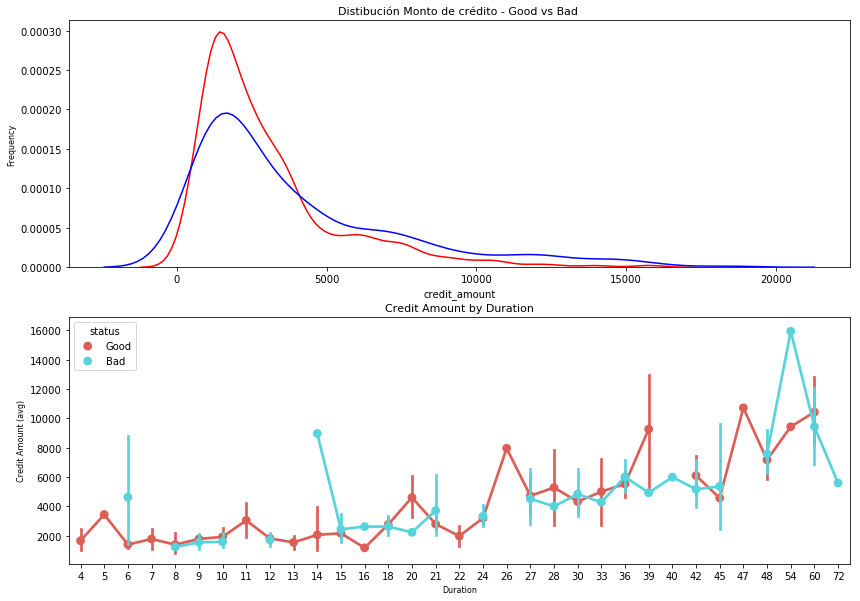

In [36]:
plt.figure(figsize = (14,10))
plt.subplot(211)
sn.distplot( dataset[dataset.status == 'Good'].credit_amount, color = 'r', hist = False )
sn.distplot( dataset[dataset.status == 'Bad'].credit_amount, color = 'b', hist = False )
plt.title("Distibución Monto de crédito - Good vs Bad ", fontsize = 11 )
plt.ylabel("Frequency", fontsize=8)

plt.subplot(212)
g1 = sn.pointplot(x="duration", y ="credit_amount",data=dataset,
                   hue="status", palette="hls")
g1.set_xlabel("Duration", fontsize=8)
g1.set_ylabel("Credit Amount (avg)", fontsize=8)
g1.set_title("Credit Amount by Duration", fontsize=11)

Observamos que los credito tienden a tener montos altos a mayor cantidad de meses.<br>
Los creditos cuando superan los <b>9000 DM </b> tiende a ser mayor su incumplimiento ,estos son comportamientos esperados.

checkin_account       A11       A12       A13       A14
status                                                 
Bad              0.492701  0.388889  0.222222  0.116751
Good             0.507299  0.611111  0.777778  0.883249


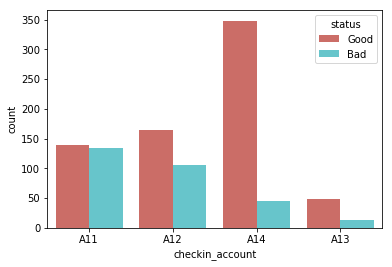

In [37]:
g = sn.countplot(x="checkin_account", data=dataset, 
              palette="hls", hue = "status")
table = dataset.pivot_table(index='status',columns = 'checkin_account' ,values='records',aggfunc='sum')
print(table.div(table.sum(axis=0), axis=1))

Los clientes que <b>NO (A14)</b> tienen una cuenta o el monto en la cuenta es <b>mayor a 200DM (A13)</b> parecen tener una menor probabilidad de incurrir en un incumplimiento.

saving_account       A61       A62       A63    A64       A65
status                                                       
Bad             0.359867  0.326923  0.174603  0.125  0.174863
Good            0.640133  0.673077  0.825397  0.875  0.825137


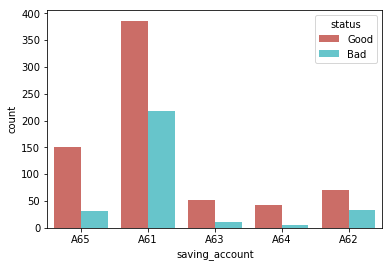

In [11]:
g = sn.countplot(x="saving_account", data=dataset, 
              palette="hls", hue = "status")
table = dataset.pivot_table(index='status',columns = 'saving_account' ,values='records',aggfunc='sum')
print(table.div(table.sum(axis=0), axis=1))

Parece haber un comportamento similar con clientes que <b>NO (A65)</b> tienen una cuenta de ahorros o el monto en la cuenta es <b>mayor a 500DM (A63 - A64)</b> parecen tener una menor probabilidad de incurrir en un incumplimiento.

# **Prepación de los datos:** 

- Starting by distribuition of column Age

In [38]:
dataset.drop('records', axis=1, inplace=True)
data =  dataset
#cambiemos manualmente las que tienen un aparente orden
data["checkin_account"] =data['checkin_account'].map({'A11': 1,'A12': 2,'A13': 3,'A14': 0})
data["saving_account"] =data['saving_account'].map({'A61': 1,'A62': 2,'A63': 3,'A64': 4,'A65': 0})
data["present_empl_since"] =data['present_empl_since'].map({'A72': 1,'A73': 2,'A74': 3,'A75': 4,'A71': 0})
data["job"] = data['job'].map({'A172': 1,'A173': 2,'A174': 3,'A171': 0})
data["status"] = data['status'].map({'Good': 1,'Bad': 2})

In [39]:
#Cambiammos las demas
enconder = defaultdict(LabelEncoder)
scaler = MinMaxScaler()
#Definimos las variables 
varDisc2 = ['credit_history','purpose','personal_status','other_debtors','property','other_install_plans','housing','telephone','foreign_worker','sex']
varNumeric2 = ['duration','credit_amount','interest_rate','residing_since','age','num_credits','dependents']
#
data[varNumeric2] = scaler.fit_transform(data[varNumeric2])
data[varDisc2] = data[varDisc2].apply(lambda x: enconder[x.name].fit_transform(x))

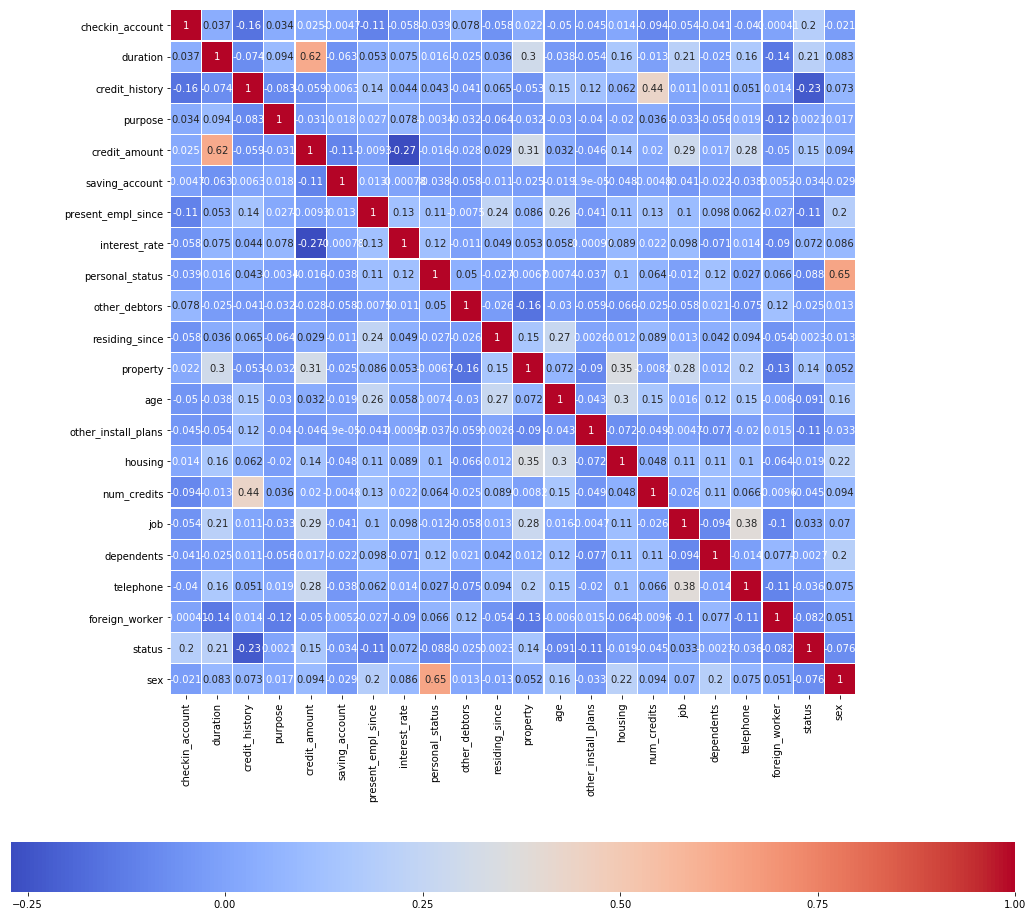

In [40]:
plt.figure(figsize=(18,18))
sn.heatmap(data.astype(float).corr(),linewidths=0.15,vmax=1.0, 
            square=True,  linecolor='white', annot=True,cmap="coolwarm",cbar=True,cbar_kws={"orientation": "horizontal"})

In [41]:
HTML(data.head(7).to_html())

,checkin_account,duration,credit_history,purpose,credit_amount,saving_account,present_empl_since,interest_rate,personal_status,other_debtors,residing_since,property,age,other_install_plans,housing,num_credits,job,dependents,telephone,foreign_worker,status,sex
0,1,0.029412,4,4,0.050567,0,4,1.000000,2,0,1.000000,0,0.857143,2,1,0.333333,2,0.0,1,0,1,1
1,2,0.647059,2,4,0.313690,1,2,0.333333,1,0,0.333333,0,0.053571,2,1,0.000000,2,0.0,0,0,2,0
2,0,0.117647,4,7,0.101574,1,3,0.333333,2,0,0.666667,0,0.535714,2,1,0.000000,1,1.0,0,0,1,1
3,1,0.558824,2,3,0.419941,1,3,0.333333,2,2,1.000000,1,0.464286,2,2,0.000000,2,1.0,0,0,1,1
4,1,0.294118,3,0,0.254209,1,2,0.666667,2,0,1.000000,3,0.607143,2,2,0.333333,2,1.0,0,0,2,1
5,0,0.470588,2,7,0.484483,0,2,0.333333,2,0,1.000000,3,0.285714,2,2,0.000000,1,1.0,1,0,1,1
6,0,0.294118,2,3,0.142236,3,4,0.666667,2,0,1.000000,1,0.607143,2,1,0.000000,2,0.0,0,0,1,1


In [79]:
y = data['status']
if 'status' in data.columns:
    dataset.drop('status', axis=1, inplace=True)
else:
    pass

In [85]:
x_train, x_test, y_train, y_test= train_test_split(data, y, test_size=0.3, random_state=42,stratify=y)
print("{} Muestras de Entrenamiento".format(y_train.shape))
print("{} Muestras de Prueba".format(y_test.shape))

(700,) Muestras de Entrenamiento
(301,) Muestras de Prueba


In [86]:
print(y_test.value_counts( normalize=False ))

1    211
2     90
Name: status, dtype: int64


# **Modelos:**
- Pasando modelos con la configuración por defecto

In [106]:
list_model = ['Dummy','KNeighbors','DecisionTree','LogisticRegression','RandomForest']
def select_modelo(modelo):
    if   modelo == "Dummy": model = DummyClassifier(strategy='most_frequent',random_state=0)
    elif modelo == "KNeighbors": model = KNeighborsClassifier()
    elif modelo == "DecisionTree": model = DecisionTreeClassifier()
    elif modelo == "LogisticRegression": model = LogisticRegression(random_state=0)
    elif modelo == "RandomForest": model = RandomForestClassifier()
    model.fit(x_train,y_train)
    pred = model.predict(x_test)
    print("Accuracy: %0.5f " % (accuracy_score(y_test,pred)))
    fig, ax = plot_confusion_matrix(conf_mat=confusion_matrix(y_test, pred))
    push_notebook()


In [107]:
interact(select_modelo, modelo=list_model)

interactive(children=(Dropdown(description='modelo', options=('Dummy', 'KNeighbors', 'DecisionTree', 'Logistic…

<function __main__.select_modelo(modelo)>

Accuracy: 0.70100 


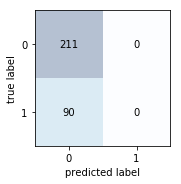

In [87]:
dummy = DummyClassifier(strategy='most_frequent',random_state=0)
dummy.fit(x_train,y_train)
pred_dummy = dummy.predict(x_test)
print("Accuracy: %0.5f " % (accuracy_score(y_test,pred_dummy)))
fig, ax = plot_confusion_matrix(conf_mat=confusion_matrix(y_test, pred_dummy))

Accuracy: 0.68771 
             precision    recall  f1-score   support

          1       0.74      0.85      0.79       211
          2       0.47      0.31      0.37        90

avg / total       0.66      0.69      0.67       301



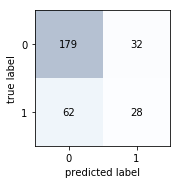

In [102]:
knn = KNeighborsClassifier()
knn.fit(x_train, y_train)
pred_knn = knn.predict(x_test)
print("Accuracy: %0.5f " % (accuracy_score(y_test,pred_knn)))
print(classification_report(y_test, pred_knn))
fig, ax = plot_confusion_matrix(conf_mat=confusion_matrix(y_test, pred_knn))

Accuracy: 0.66113 
             precision    recall  f1-score   support

          1       0.76      0.75      0.76       211
          2       0.44      0.46      0.45        90

avg / total       0.67      0.66      0.66       301



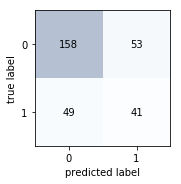

In [99]:
dtc = DecisionTreeClassifier()
dtc.fit(x_train, y_train)
y_pred_dtc=dtc.predict(x_test) 
print("Accuracy: %0.5f " % (accuracy_score(y_test,y_pred_dtc)))
print(classification_report(y_test, y_pred_dtc))
fig, ax = plot_confusion_matrix(conf_mat=confusion_matrix(y_test, y_pred_dtc))

Accuracy: 0.74419 
             precision    recall  f1-score   support

          1       0.78      0.89      0.83       211
          2       0.61      0.40      0.48        90

avg / total       0.73      0.74      0.73       301



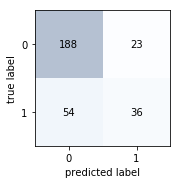

In [88]:
logreg = LogisticRegression(random_state=0)
logreg.fit(x_train, y_train)
pred_logreg = logreg.predict(x_test)
print("Accuracy: %0.5f " % (accuracy_score(y_test,pred_logreg)))
print(classification_report(y_test, pred_logreg))
fig, ax = plot_confusion_matrix(conf_mat=confusion_matrix(y_test, pred_logreg))

Accuracy: 0.74086 
             precision    recall  f1-score   support

          1       0.78      0.88      0.83       211
          2       0.59      0.42      0.49        90

avg / total       0.72      0.74      0.73       301



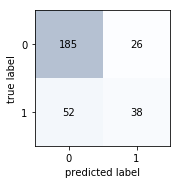

In [98]:
rfc = RandomForestClassifier()
rfc.fit(x_train, y_train)
y_pred_rfc=rfc.predict(x_test) 
print("Accuracy: %0.5f " % (accuracy_score(y_test,y_pred_rfc)))
print(classification_report(y_test, y_pred_rfc))
fig, ax = plot_confusion_matrix(conf_mat=confusion_matrix(y_test, y_pred_rfc))

In [89]:
def fit_trees(algo, n_jobs, max_depth, n_estimators):
    if algo == "Decision Trees": 
        estimator = DecisionTreeClassifier() 
    else: 
        estimator = RandomForestClassifier() 
#
    cv = ShuffleSplit(n_splits=10,test_size=0.2)
    if algo == "Decision Trees": 
        classifier = GridSearchCV(estimator=estimator, cv=cv, 
                                  param_grid=dict(max_depth=max_depth), n_jobs=n_jobs, scoring='f1') 
    else: 
        classifier = GridSearchCV(estimator=estimator, cv=cv, 
                                  param_grid=dict(n_estimators=n_estimators, max_depth=max_depth), n_jobs=n_jobs, scoring='f1')

    classifier.fit(x_train, y_train)
    print ("Best Estimator learned through GridSearch")
    print (classifier.best_estimator_)
    return cv, classifier.best_estimator_.max_depth, classifier.best_estimator_.n_estimators

In [92]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):

    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    #plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="b")
    
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="b",label="Cross-validation score")

    plt.legend(loc="best")
    return plt

In [90]:
max_depth=np.linspace(5,10,5) 
n_estimators=[10, 100, 500, 1000]
cv,max_depth,n_estimators=fit_trees('Random Forests', n_jobs=10, max_depth=max_depth, n_estimators=n_estimators)

Best Estimator learned through GridSearch
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=6.25, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


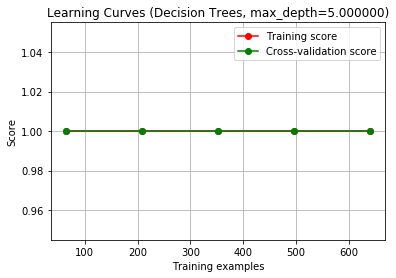

In [28]:
title = "Learning Curves (Decision Trees, max_depth=%.6f)" %(max_depth) 
estimator = DecisionTreeClassifier(max_depth=max_depth) 
plot_learning_curve(estimator, title, x_train, y_train, cv=cv) 
plt.show() 

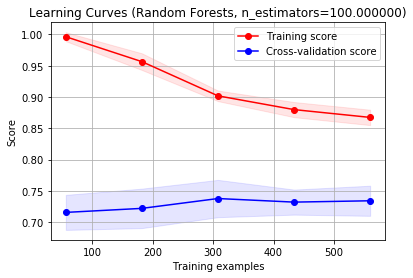

In [93]:
title = "Learning Curves (Random Forests, n_estimators=%.6f)" %(n_estimators) 
estimator = RandomForestClassifier(n_estimators=n_estimators,max_depth=max_depth) 
plot_learning_curve(estimator, title, x_train, y_train, cv=cv) 

Accuracy: 0.76744 
             precision    recall  f1-score   support

          1       0.77      0.96      0.85       211
          2       0.78      0.31      0.44        90

avg / total       0.77      0.77      0.73       301



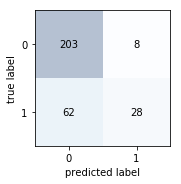

In [96]:
estimator.fit(x_train, y_train) 
y_pred_rdmf=estimator.predict(x_test) 
print("Accuracy: %0.5f " % (accuracy_score(y_test,y_pred_rdmf)))
print(classification_report(y_test, y_pred_rdmf))
fig, ax = plot_confusion_matrix(conf_mat=confusion_matrix(y_test, y_pred_rdmf))